In [1]:
import os

from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient
from dotenv import load_dotenv
import httpx

load_dotenv()

api_version = os.getenv("AZURE_OPENAI_API_VERSION")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
azure_openai_chat_completion_client = AzureOpenAIChatCompletionClient(
            model=deployment_name,
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            api_key=api_key,
        )

# RapidAPI 키 없이 wttr.in을 활용한 간단 날씨 함수
async def get_weather(city: str) -> str:
    url = f"https://wttr.in/{city}?format=3"
    try:
        async with httpx.AsyncClient() as client:
            resp = await client.get(url)
            if resp.status_code == 200:
                return resp.text.strip()
            else:
                return f"{city}의 날씨 정보를 가져올 수 없습니다. (status: {resp.status_code})"
    except Exception as e:
        return f"날씨 정보를 가져오는 중 오류 발생: {e}"


async def main() -> None:
    # Define an agent
    weather_agent = AssistantAgent(
        name="weather_agent",
        model_client=azure_openai_chat_completion_client,
        tools=[get_weather],
    )

    # Define a team with a single agent and maximum auto-gen turns of 1.
    agent_team = RoundRobinGroupChat([weather_agent], max_turns=1)

    while True:
        # Get user input from the console.
        user_input = input("Enter a message (type 'exit' to leave): ")
        if user_input.strip().lower() == "exit":
            break
        # Run the team and stream messages to the console.
        stream = agent_team.run_stream(task=user_input)
        await Console(stream)

# NOTE: if running this inside a Python script you'll need to use asyncio.run(main()).
await main()

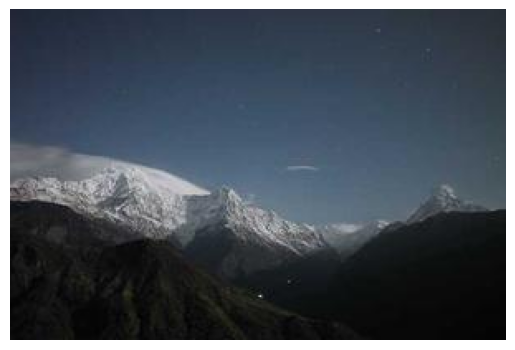

['The image depicts a nighttime scene of a mountainous landscape. Snow-covered peaks are visible under a dark sky, illuminated softly, possibly by moonlight. The sky appears to be clear with some faint stars visible, adding to the serene and tranquil atmosphere of the scene. The lower slopes of the mountains are dark, covered with forests or rugged terrain. The overall mood is calm and peaceful.']
id='eccdd85f-c6a9-408c-bb36-2f7afbcff965' source='assistant' models_usage=RequestUsage(prompt_tokens=99, completion_tokens=77) metadata={} created_at=datetime.datetime(2025, 7, 25, 7, 45, 18, 68513, tzinfo=datetime.timezone.utc) content='The image depicts a nighttime scene of a mountainous landscape. Snow-covered peaks are visible under a dark sky, illuminated softly, possibly by moonlight. The sky appears to be clear with some faint stars visible, adding to the serene and tranquil atmosphere of the scene. The lower slopes of the mountains are dark, covered with forests or rugged terrain. The

In [29]:
from autogen_agentchat.messages import TextMessage

text_message = TextMessage(content="Hello, world!", source="User")

from io import BytesIO

import matplotlib.pyplot as plt
import requests
from autogen_agentchat.messages import MultiModalMessage
from autogen_core import CancellationToken
from autogen_core import Image as AGImage
from PIL import Image

pil_image = Image.open(BytesIO(requests.get("https://picsum.photos/300/200").content))
img = AGImage(pil_image)
multi_modal_message = MultiModalMessage(content=["Can you describe the content of this image?", img], source="User")
plt.imshow(pil_image) 
plt.axis('off') 
plt.show()

agent = AssistantAgent(
    name="assistant",
    model_client=azure_openai_chat_completion_client,
    system_message="Use tools to solve tasks.",
)

async def assistant_run() -> None:
    response = await agent.on_messages(
        [multi_modal_message],
        cancellation_token=CancellationToken(),
    )

    print([response.chat_message.content])

    print(response.chat_message)



# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

In [5]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken

from IPython.display import display
from bs4 import BeautifulSoup
import re
import httpx

# 네이버 검색 크롤링 기반 웹 검색 함수
async def web_search(query: str) -> str:
    search_url = f"https://search.naver.com/search.naver?query={query}"
    try:
        async with httpx.AsyncClient() as client:
            resp = await client.get(search_url, headers={"User-Agent": "Mozilla/5.0"})
            if resp.status_code == 200:
                soup = BeautifulSoup(resp.text, "html.parser")
                # 대표 요약문 추출 (지식백과, 파워링크, 뉴스 등 다양한 위치)
                desc = soup.select_one(".api_knowledge_summary .summary_text")
                if desc:
                    return desc.get_text(strip=True)
                desc = soup.select_one(".total_group .total_dsc")
                if desc:
                    return desc.get_text(strip=True)
                desc = soup.select_one(".news_dsc")
                if desc:
                    return desc.get_text(strip=True)
                desc = soup.find("meta", {"name": "description"})
                if desc and desc.get("content"):
                    return desc["content"]
                text = soup.get_text()
                m = re.search(r"([\w가-힣 ,\.\-]+)[\.!?]", text)
                if m:
                    return m.group(1)
                return "검색 결과가 없습니다."
            else:
                return f"검색 정보를 가져올 수 없습니다. (status: {resp.status_code})"
    except Exception as e:
        return f"검색 정보를 가져오는 중 오류 발생: {e}"

# Create an agent that uses the OpenAI GPT-4o model.
model_client = azure_openai_chat_completion_client
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )
    display(response.inner_messages)
    display(response.chat_message.content)

# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()


[ToolCallRequestEvent(id='6cbdc1af-9618-4178-a9ae-9a50c1c38181', source='assistant', models_usage=RequestUsage(prompt_tokens=55, completion_tokens=16), metadata={}, created_at=datetime.datetime(2025, 7, 25, 7, 58, 53, 480483, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_ho7bIIH4NEZ0OHY0qOSGJoCy', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'),
 ToolCallExecutionEvent(id='1d4ebc81-ef09-4c74-8950-1473dd9d39c5', source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 25, 7, 58, 54, 452875, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content="'AutoGen'의 네이버 검색 결과입니다.", name='web_search', call_id='call_ho7bIIH4NEZ0OHY0qOSGJoCy', is_error=False)], type='ToolCallExecutionEvent')]

"'AutoGen'의 네이버 검색 결과입니다."

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken

from IPython.display import display


# SerpAPI를 활용한 웹 검색 함수 (API 키 필요, .env에 SERPAPI_KEY 추가)
import os
import httpx



async def web_search(query: str) -> str:
    serpapi_key = os.getenv("SERPAPI_KEY")
    if not serpapi_key:
        return "SerpAPI 키가 설정되어 있지 않습니다. .env 파일에 SERPAPI_KEY를 추가하세요."
    url = "https://serpapi.com/search.json"
    params = {
        "q": query,
        "hl": "ko",
        "gl": "kr",
        "api_key": serpapi_key
    }
    try:
        async with httpx.AsyncClient() as client:
            resp = await client.get(url, params=params)
            if resp.status_code == 200:
                data = resp.json()
                answer = data.get("answer_box", {}).get("answer")
                if answer:
                    return answer
                organic = data.get("organic_results", [])
                if organic and len(organic) > 0:
                    snippet = organic[0].get("snippet")
                    if snippet:
                        return snippet
                    title = organic[0].get("title")
                    link = organic[0].get("link")
                    if title and link:
                        return f"{title}\n{link}"
                return "검색 결과가 없습니다."
            else:
                return f"검색 정보를 가져올 수 없습니다. (status: {resp.status_code})"
    except Exception as e:
        return f"검색 정보를 가져오는 중 오류 발생: {e}"


# Create an agent that uses the OpenAI GPT-4o model.
model_client = azure_openai_chat_completion_client
agent = AssistantAgent(
    name="assistant",
    model_client=model_client,
    tools=[web_search],
    system_message="Use tools to solve tasks.",
)

async def assistant_run() -> None:
    response = await agent.on_messages(
        [TextMessage(content="Find information on AutoGen", source="user")],
        cancellation_token=CancellationToken(),
    )

    print(response.inner_messages)
    print()
    display(response.chat_message.content)


# Use asyncio.run(assistant_run()) when running in a script.
await assistant_run()

[ToolCallRequestEvent(id='a1bfb3cb-d41b-4fa5-845a-7a1aa83d78eb', source='assistant', models_usage=RequestUsage(prompt_tokens=55, completion_tokens=16), metadata={}, created_at=datetime.datetime(2025, 7, 25, 8, 22, 43, 590248, tzinfo=datetime.timezone.utc), content=[FunctionCall(id='call_LmO64Wp9TaUxoElcP1h1eCcg', arguments='{"query":"AutoGen"}', name='web_search')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(id='a6ad6096-3455-4241-b6fc-79c0cfc86da5', source='assistant', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 25, 8, 22, 43, 641937, tzinfo=datetime.timezone.utc), content=[FunctionExecutionResult(content='An event-driven programming framework for building scalable multi-agent AI systems. Example scenarios: Deterministic and dynamic agentic workflows for business ...', name='web_search', call_id='call_LmO64Wp9TaUxoElcP1h1eCcg', is_error=False)], type='ToolCallExecutionEvent')]



'An event-driven programming framework for building scalable multi-agent AI systems. Example scenarios: Deterministic and dynamic agentic workflows for business ...'

In [31]:
from autogen_agentchat.agents import UserProxyAgent
from autogen_agentchat.messages import TextMessage
from autogen_core import CancellationToken


async def user_proxy_run() -> None:
    user_proxy_agent = UserProxyAgent("user_proxy")
    response = await user_proxy_agent.on_messages(
        [TextMessage(content="What is your name? ", source="user")], cancellation_token=CancellationToken()
    )
    print(f"Your name is {response.chat_message.content}")


# Use asyncio.run(user_proxy_run()) when running in a script.
await user_proxy_run()

Your name is exit


In [32]:
from autogen_agentchat.ui import Console


async def assistant_run_stream() -> None:
    # Option 1: read each message from the stream (as shown in the previous example).
    # async for message in agent.on_messages_stream(
    #     [TextMessage(content="Find information on AutoGen", source="user")],
    #     cancellation_token=CancellationToken(),
    # ):
    #     print(message)

    # Option 2: use Console to print all messages as they appear.
    await Console(
        agent.on_messages_stream(
            [TextMessage(content="Find information on AutoGen", source="user")],
            cancellation_token=CancellationToken(),
        )
    )


# Use asyncio.run(assistant_run_stream()) when running in a script.
await assistant_run_stream()

---------- ToolCallRequestEvent (assistant) ----------
[FunctionCall(id='call_J0YrQjZn7F0PNJl37NjABXKF', arguments='{"query":"AutoGen"}', name='web_search')]
[FunctionCall(id='call_J0YrQjZn7F0PNJl37NjABXKF', arguments='{"query":"AutoGen"}', name='web_search')]
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='검색 정보를 가져올 수 없습니다. (status: 401)', name='web_search', call_id='call_J0YrQjZn7F0PNJl37NjABXKF', is_error=False)]
---------- assistant ----------
검색 정보를 가져올 수 없습니다. (status: 401)
---------- ToolCallExecutionEvent (assistant) ----------
[FunctionExecutionResult(content='검색 정보를 가져올 수 없습니다. (status: 401)', name='web_search', call_id='call_J0YrQjZn7F0PNJl37NjABXKF', is_error=False)]
---------- assistant ----------
검색 정보를 가져올 수 없습니다. (status: 401)


In [33]:
from autogen_core.memory import ListMemory, MemoryContent, MemoryMimeType

# Initialize user memory
user_memory = ListMemory()

# Add user preferences to memory
await user_memory.add(MemoryContent(content="난 고양이를 좋아해", mime_type=MemoryMimeType.TEXT))

await user_memory.add(MemoryContent(content="내 생일은 7월 31 일이야", mime_type=MemoryMimeType.TEXT))

assistant_agent = AssistantAgent(
    name="assistant_agent",
    model_client=azure_openai_chat_completion_client,
    memory=[user_memory],
)

stream = assistant_agent.run_stream(task="내 생일은 언제야? 내가 좋아하는 애완동물은?")
await Console(stream)

---------- TextMessage (user) ----------
내 생일은 언제야? 내가 좋아하는 애완동물은?
---------- MemoryQueryEvent (assistant_agent) ----------
[MemoryContent(content='난 고양이를 좋아해', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None), MemoryContent(content='내 생일은 7월 31 일이야', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None)]
내 생일은 언제야? 내가 좋아하는 애완동물은?
---------- MemoryQueryEvent (assistant_agent) ----------
[MemoryContent(content='난 고양이를 좋아해', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None), MemoryContent(content='내 생일은 7월 31 일이야', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None)]
---------- TextMessage (assistant_agent) ----------
당신의 생일은 7월 31일이고, 좋아하는 애완동물은 고양이입니다.
---------- TextMessage (assistant_agent) ----------
당신의 생일은 7월 31일이고, 좋아하는 애완동물은 고양이입니다.


TaskResult(messages=[TextMessage(id='d14a44e0-e453-45d3-8f2a-24cbd403fca0', source='user', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 25, 7, 45, 24, 723321, tzinfo=datetime.timezone.utc), content='내 생일은 언제야? 내가 좋아하는 애완동물은?', type='TextMessage'), MemoryQueryEvent(id='1e821b5c-99ba-4489-b155-09286cf4ce40', source='assistant_agent', models_usage=None, metadata={}, created_at=datetime.datetime(2025, 7, 25, 7, 45, 24, 726554, tzinfo=datetime.timezone.utc), content=[MemoryContent(content='난 고양이를 좋아해', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None), MemoryContent(content='내 생일은 7월 31 일이야', mime_type=<MemoryMimeType.TEXT: 'text/plain'>, metadata=None)], type='MemoryQueryEvent'), TextMessage(id='6f6b0826-7095-4697-820a-d40ed9b71a97', source='assistant_agent', models_usage=RequestUsage(prompt_tokens=88, completion_tokens=27), metadata={}, created_at=datetime.datetime(2025, 7, 25, 7, 45, 25, 384343, tzinfo=datetime.timezone.utc), content='당신의 생일은 7월 31일이고

LLM 은 stateless, 말만 많음, 거짓말쟁이



LLM에 단기 메모리, 꼭 기억해야하는 메모리, 여러 툴, mcp를 연결을 잘 해놓는 것이 context engineering
